# Análise de Clustering para Perfis de Olhos
## Utilizando K-Means, K-Medoids e DBSCAN

Este notebook implementa uma análise comparativa de clustering utilizando três algoritmos diferentes para identificar perfis de olhos baseados em medidas anatômicas específicas.

### Objetivo
Encontrar os perfis de olhos (clustering) baseado nas seguintes medidas:
- **AL** = comprimento axial do olho
- **ACD** = profundidade de câmara anterior  
- **WTW** = distância branco a branco
- **K1** = curvatura no meridiano menos curvo
- **K2** = curvatura no meridiano mais curvo

### Métodos Implementados
1. **K-Means**: Algoritmo de particionamento baseado em centroides
2. **K-Medoids**: Algoritmo robusto baseado em medoides
3. **DBSCAN**: Algoritmo baseado em densidade que identifica clusters e ruído

## 1. Importação de Bibliotecas e Carregamento dos Dados

In [1]:
# Importação de bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Bibliotecas importadas com sucesso!")

# Carregamento dos dados
data_path = Path('data/barrettII_eyes_clustering.csv')
df = pd.read_csv(data_path)

print(f"\nDados carregados:")
print(f"Dimensões do dataset: {df.shape}")
print(f"Colunas: {list(df.columns)}")
print(f"\nPrimeiras 5 linhas:")
print(df.head())

Bibliotecas importadas com sucesso!

Dados carregados:
Dimensões do dataset: (1528, 7)
Colunas: ['ID', 'AL', 'ACD', 'WTW', 'K1', 'K2', 'Correto']

Primeiras 5 linhas:
   ID     AL   ACD   WTW     K1     K2 Correto
0   0  23.79  3.32  12.0  43.60  44.29       S
1   1  24.60  3.39  12.3  42.03  43.95       S
2   2  24.59  3.51  12.3  42.83  43.05       S
3   3  24.04  2.96  12.0  42.35  42.83       S
4   4  24.80  2.44  12.2  41.01  41.67       S


## 2. Análise Exploratória dos Dados

In [2]:
# Estatísticas descritivas gerais
print("INFORMAÇÕES GERAIS DO DATASET")
print("="*50)
print(df.info())
print("\n" + "="*50)
print("ESTATÍSTICAS DESCRITIVAS")
print("="*50)
print(df.describe())

INFORMAÇÕES GERAIS DO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       1528 non-null   int64  
 1   AL       1528 non-null   float64
 2   ACD      1528 non-null   float64
 3   WTW      1528 non-null   float64
 4   K1       1528 non-null   float64
 5   K2       1528 non-null   float64
 6   Correto  1528 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 83.7+ KB
None

ESTATÍSTICAS DESCRITIVAS
               ID           AL          ACD          WTW           K1  \
count  1528.00000  1528.000000  1528.000000  1528.000000  1528.000000   
mean    763.50000    23.486525     3.106728    11.975098    43.469188   
std     441.23992     1.142280     0.428881     0.431712     1.745504   
min       0.00000    20.150000     1.130000     9.900000    30.930000   
25%     381.75000    22.760000     2.830000    11.700000    42.

In [3]:
# Verificação de valores ausentes
print("VERIFICAÇÃO DE VALORES AUSENTES")
print("="*50)
print(df.isnull().sum())

# Análise das variáveis de clustering
features = ['AL', 'ACD', 'WTW', 'K1', 'K2']
print(f"\n\nESTATÍSTICAS DAS VARIÁVEIS DE CLUSTERING")
print("="*50)
print(df[features].describe())

VERIFICAÇÃO DE VALORES AUSENTES
ID         0
AL         0
ACD        0
WTW        0
K1         0
K2         0
Correto    0
dtype: int64


ESTATÍSTICAS DAS VARIÁVEIS DE CLUSTERING
                AL          ACD          WTW           K1           K2
count  1528.000000  1528.000000  1528.000000  1528.000000  1528.000000
mean     23.486525     3.106728    11.975098    43.469188    44.370386
std       1.142280     0.428881     0.431712     1.745504     1.767765
min      20.150000     1.130000     9.900000    30.930000    33.950000
25%      22.760000     2.830000    11.700000    42.450000    43.270000
50%      23.360000     3.080000    12.000000    43.490000    44.290000
75%      24.080000     3.360000    12.300000    44.530000    45.490000
max      30.960000     5.230000    13.300000    49.410000    52.410000


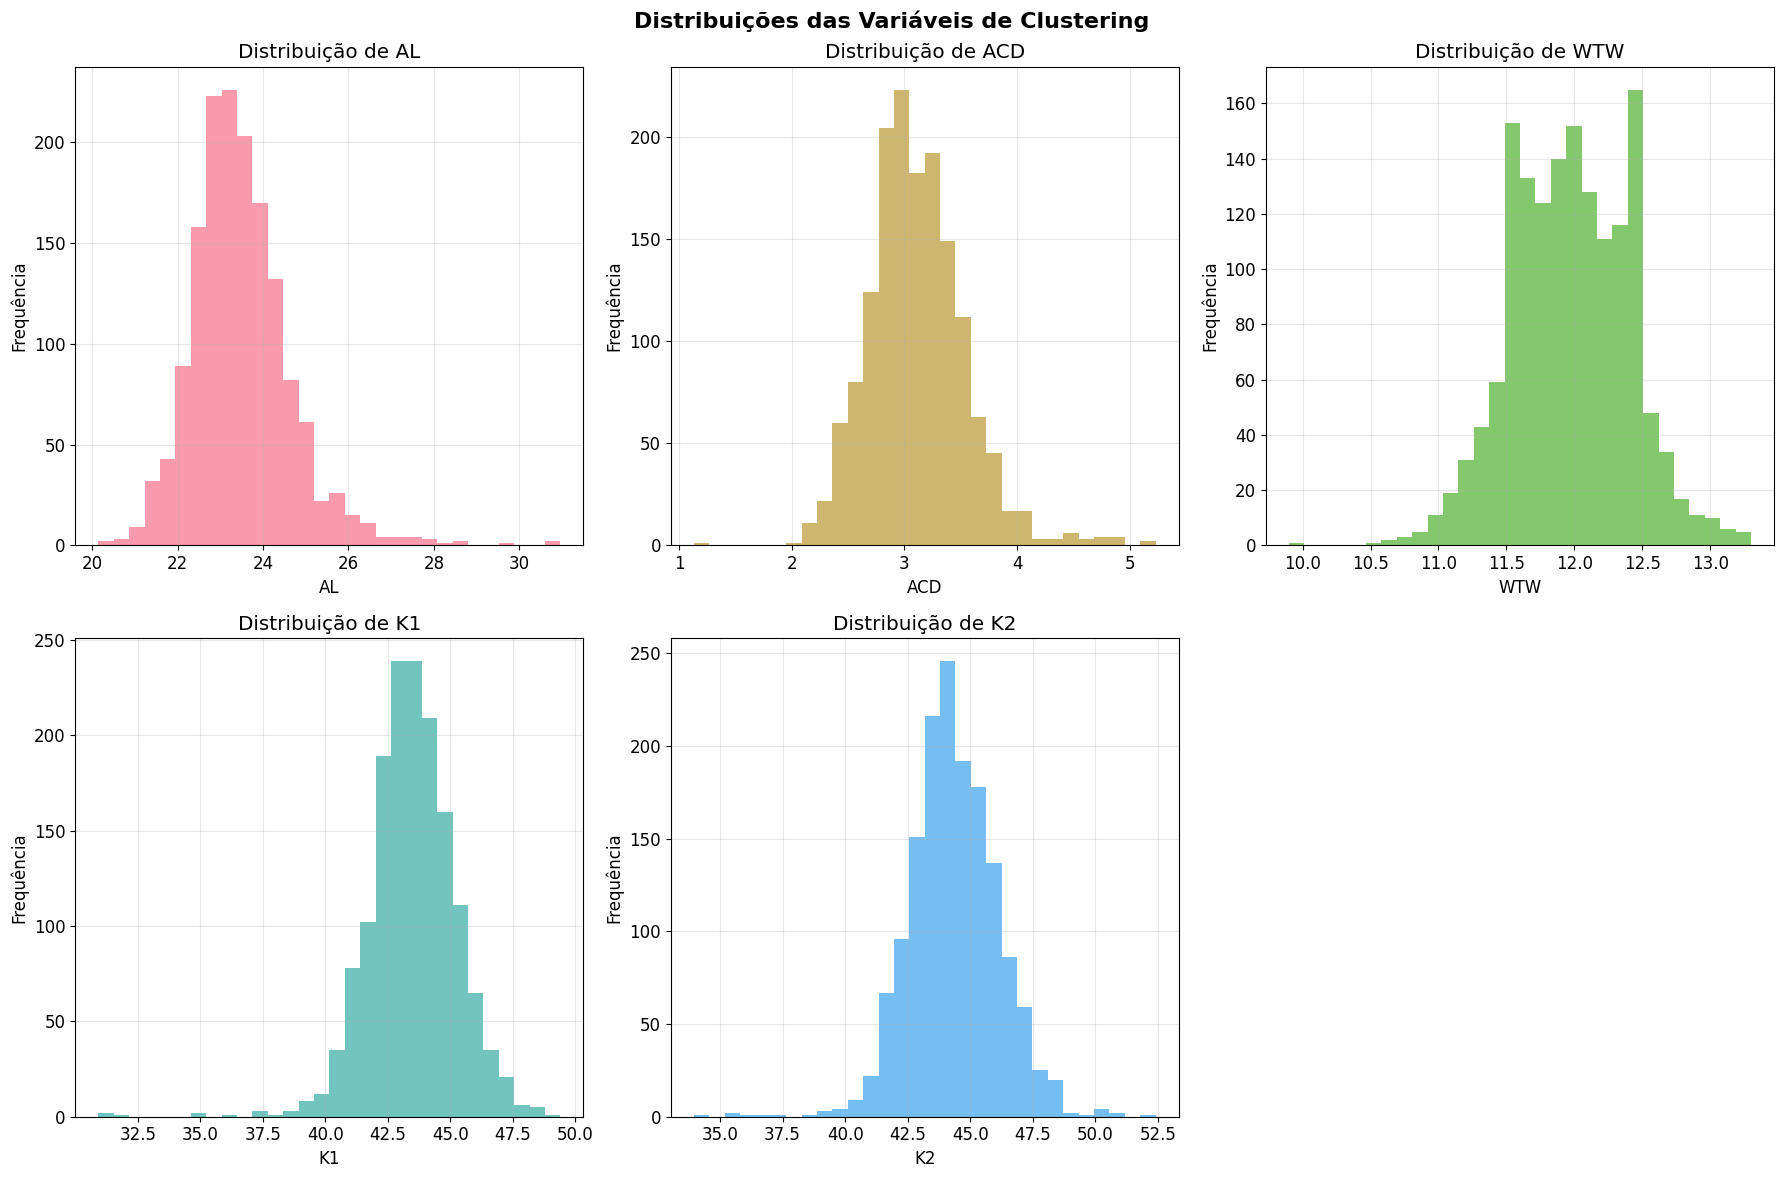

In [4]:
# Visualização das distribuições das variáveis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribuições das Variáveis de Clustering', fontsize=16, fontweight='bold')

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    
    # Histograma
    axes[row, col].hist(df[feature], bins=30, alpha=0.7, color=sns.color_palette("husl")[i])
    axes[row, col].set_title(f'Distribuição de {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequência')
    axes[row, col].grid(True, alpha=0.3)

# Remove o subplot extra
axes[1, 2].remove()

plt.tight_layout()
plt.show()

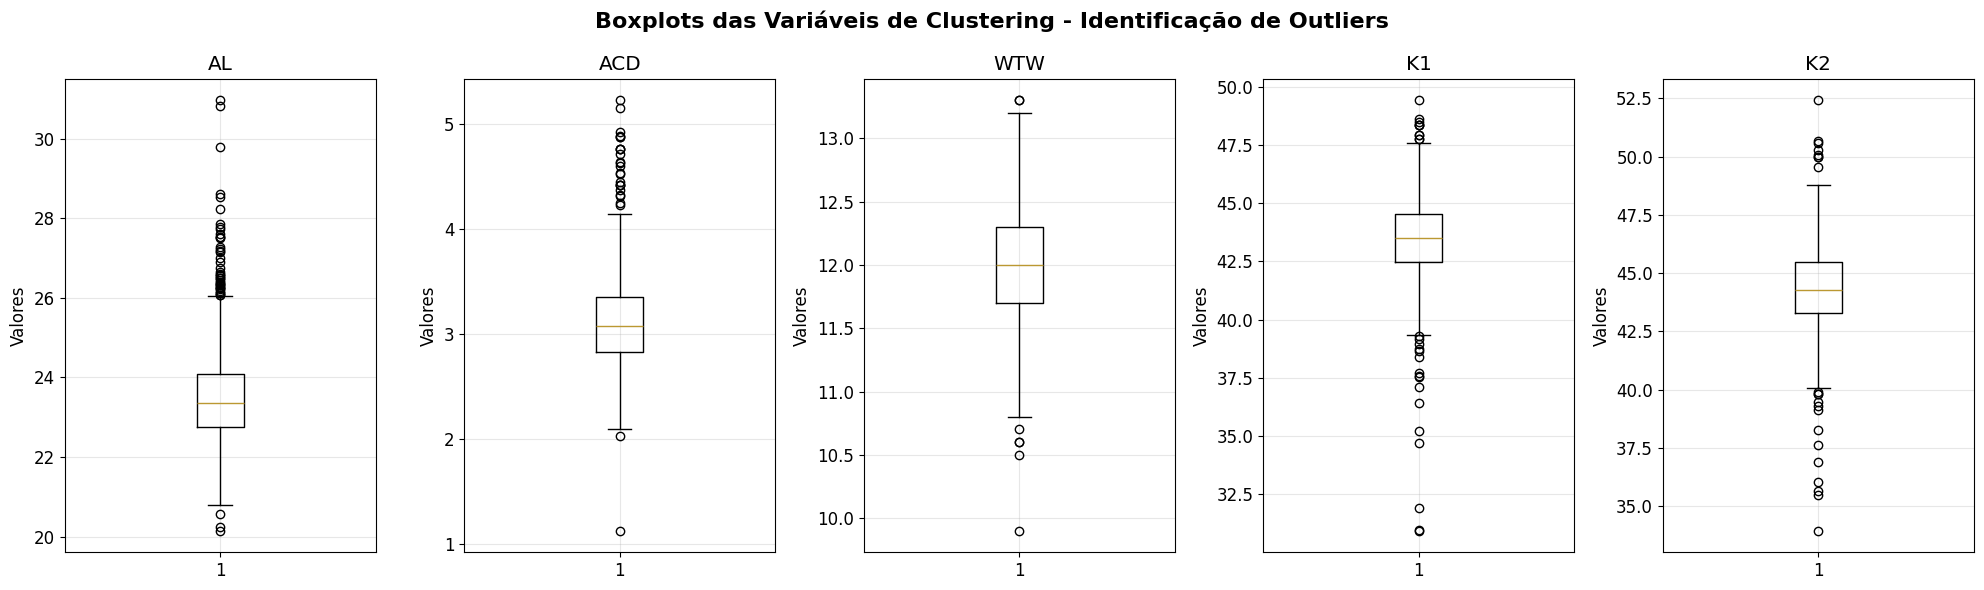

In [5]:
# Boxplots para identificar outliers
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Boxplots das Variáveis de Clustering - Identificação de Outliers', fontsize=16, fontweight='bold')

for i, feature in enumerate(features):
    axes[i].boxplot(df[feature])
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('Valores')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Pré-processamento dos Dados

In [6]:
# Seleção das features para clustering
features = ['AL', 'ACD', 'WTW', 'K1', 'K2']
X = df[features].copy()

print("DADOS ORIGINAIS PARA CLUSTERING")
print("="*50)
print(f"Shape dos dados: {X.shape}")
print(f"Features selecionadas: {features}")
print(f"\nPrimeiras 5 linhas:")
print(X.head())

# Normalização/Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print(f"\n\nDADOS PADRONIZADOS")
print("="*50)
print("Estatísticas após padronização (devem ter média ~0 e desvio padrão ~1):")
print(X_scaled_df.describe())

DADOS ORIGINAIS PARA CLUSTERING
Shape dos dados: (1528, 5)
Features selecionadas: ['AL', 'ACD', 'WTW', 'K1', 'K2']

Primeiras 5 linhas:
      AL   ACD   WTW     K1     K2
0  23.79  3.32  12.0  43.60  44.29
1  24.60  3.39  12.3  42.03  43.95
2  24.59  3.51  12.3  42.83  43.05
3  24.04  2.96  12.0  42.35  42.83
4  24.80  2.44  12.2  41.01  41.67


DADOS PADRONIZADOS
Estatísticas após padronização (devem ter média ~0 e desvio padrão ~1):
                 AL           ACD           WTW            K1            K2
count  1.528000e+03  1.528000e+03  1.528000e+03  1.528000e+03  1.528000e+03
mean  -1.667078e-15 -2.278573e-16  4.324638e-15  2.476204e-15  8.695778e-16
std    1.000327e+00  1.000327e+00  1.000327e+00  1.000327e+00  1.000327e+00
min   -2.921891e+00 -4.610540e+00 -4.808246e+00 -7.186059e+00 -5.896597e+00
25%   -6.362388e-01 -6.454427e-01 -6.374348e-01 -5.840847e-01 -6.226769e-01
50%   -1.108015e-01 -6.234008e-02  5.770047e-02  1.192683e-02 -4.548820e-02
75%    5.197233e-01  5.907348

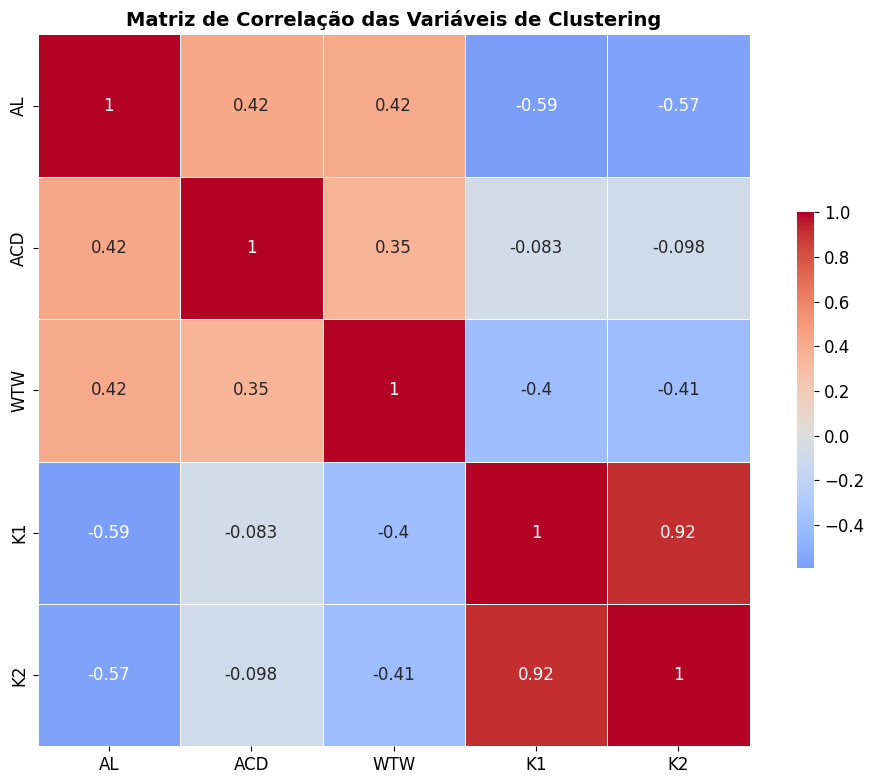

ANÁLISE DA CORRELAÇÃO
Correlações mais fortes (|r| > 0.5):
AL vs K1: -0.595
AL vs K2: -0.575
K1 vs K2: 0.918


In [7]:
# Matriz de correlação
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Matriz de Correlação das Variáveis de Clustering', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("ANÁLISE DA CORRELAÇÃO")
print("="*50)
print("Correlações mais fortes (|r| > 0.5):")
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            print(f"{features[i]} vs {features[j]}: {corr_value:.3f}")

## 4. Clustering com K-Means

### 4.1 Determinação do Número Ótimo de Clusters

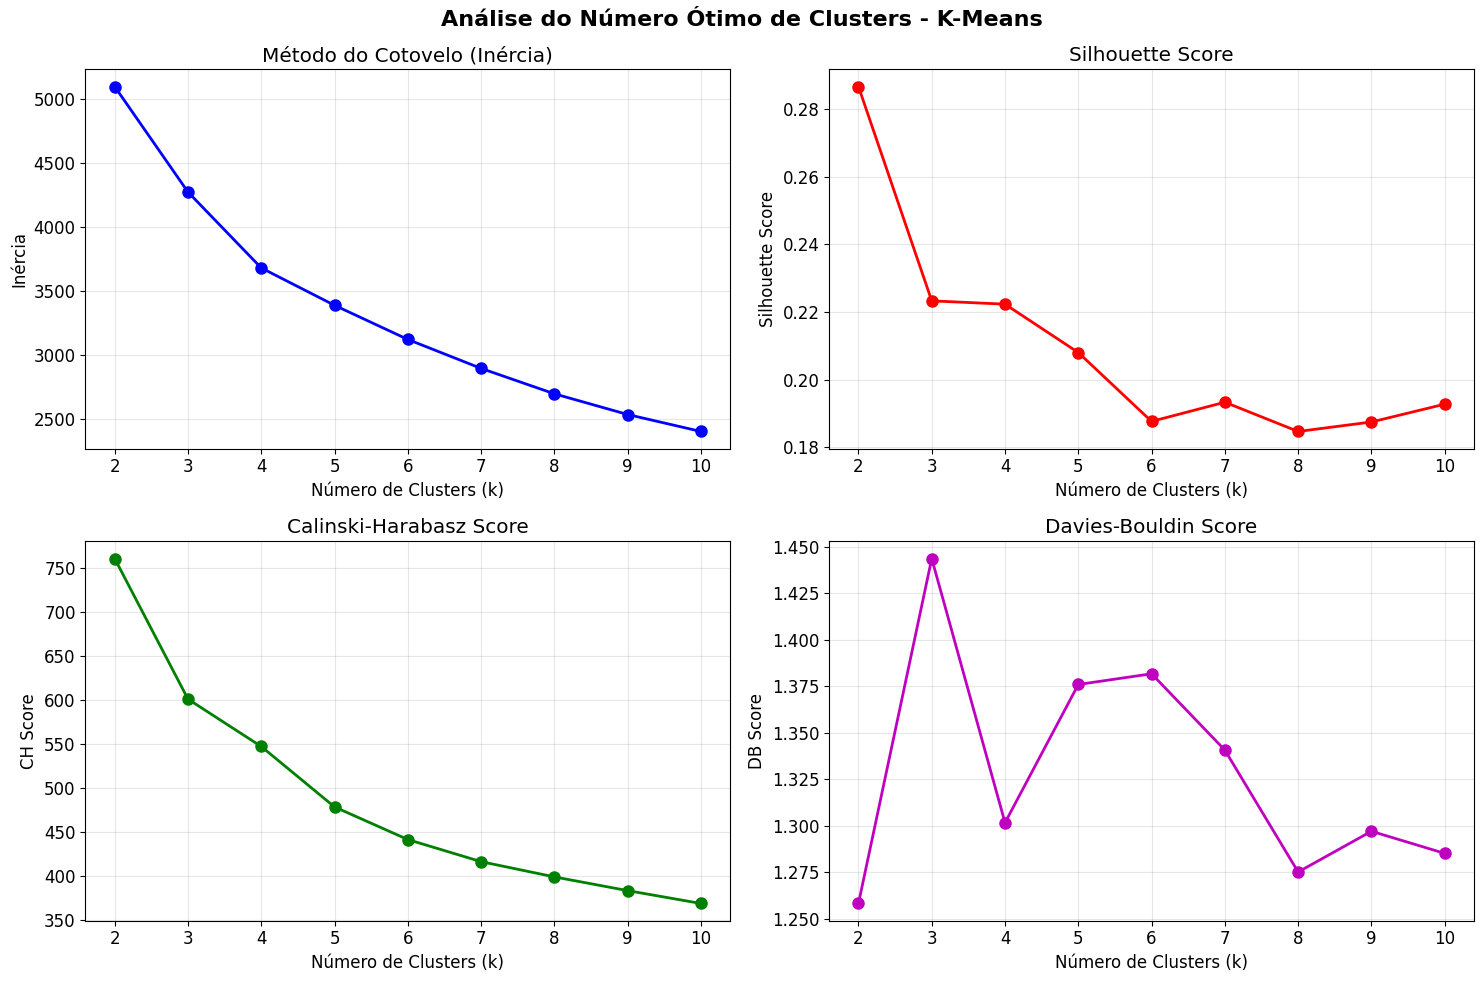

ANÁLISE DO NÚMERO ÓTIMO DE CLUSTERS - K-MEANS
Melhor k baseado no Silhouette Score: 2 (Score: 0.2867)
Melhor k baseado no Calinski-Harabasz: 2 (Score: 760.43)
Melhor k baseado no Davies-Bouldin: 2 (Score: 1.2582)


In [8]:
# Método do cotovelo e análise de métricas para K-Means
def evaluate_kmeans_clusters(X, max_k=10):
    """Avalia diferentes números de clusters para K-Means"""
    k_range = range(2, max_k + 1)
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, labels))
    
    return k_range, inertias, silhouette_scores, calinski_scores, davies_bouldin_scores

# Avaliação para diferentes valores de k
k_range, inertias, sil_scores, cal_scores, db_scores = evaluate_kmeans_clusters(X_scaled, max_k=10)

# Visualização das métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análise do Número Ótimo de Clusters - K-Means', fontsize=16, fontweight='bold')

# Método do cotovelo
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Método do Cotovelo (Inércia)')
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Inércia')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(k_range, sil_scores, 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_title('Silhouette Score')
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[1, 0].plot(k_range, cal_scores, 'go-', linewidth=2, markersize=8)
axes[1, 0].set_title('Calinski-Harabasz Score')
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('CH Score')
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin Score (menor é melhor)
axes[1, 1].plot(k_range, db_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_title('Davies-Bouldin Score')
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('DB Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar o melhor k baseado no silhouette score
best_k_sil = k_range[np.argmax(sil_scores)]
print(f"ANÁLISE DO NÚMERO ÓTIMO DE CLUSTERS - K-MEANS")
print("="*60)
print(f"Melhor k baseado no Silhouette Score: {best_k_sil} (Score: {max(sil_scores):.4f})")
print(f"Melhor k baseado no Calinski-Harabasz: {k_range[np.argmax(cal_scores)]} (Score: {max(cal_scores):.2f})")
print(f"Melhor k baseado no Davies-Bouldin: {k_range[np.argmin(db_scores)]} (Score: {min(db_scores):.4f})")

### 4.2 Aplicação do K-Means com o Número Ótimo de Clusters

In [9]:
# Configurações para K-Means
KMEANS_N_CLUSTERS = 3  # Configurável baseado na análise anterior

# Aplicação do K-Means
kmeans = KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Métricas de avaliação
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_cal = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"RESULTADOS K-MEANS (k={KMEANS_N_CLUSTERS})")
print("="*50)
print(f"Silhouette Score: {kmeans_sil:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_cal:.2f}")
print(f"Davies-Bouldin Score: {kmeans_db:.4f}")
print(f"Inércia: {kmeans.inertia_:.2f}")

# Adicionar labels ao dataframe
df_kmeans = df.copy()
df_kmeans['KMeans_Cluster'] = kmeans_labels

# Contagem de pontos por cluster
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print(f"\nDistribuição dos pontos por cluster:")
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} pontos ({count/len(kmeans_labels)*100:.1f}%)")

RESULTADOS K-MEANS (k=3)
Silhouette Score: 0.2233
Calinski-Harabasz Score: 600.67
Davies-Bouldin Score: 1.4436
Inércia: 4273.52

Distribuição dos pontos por cluster:
Cluster 0: 457 pontos (29.9%)
Cluster 1: 372 pontos (24.3%)
Cluster 2: 699 pontos (45.7%)


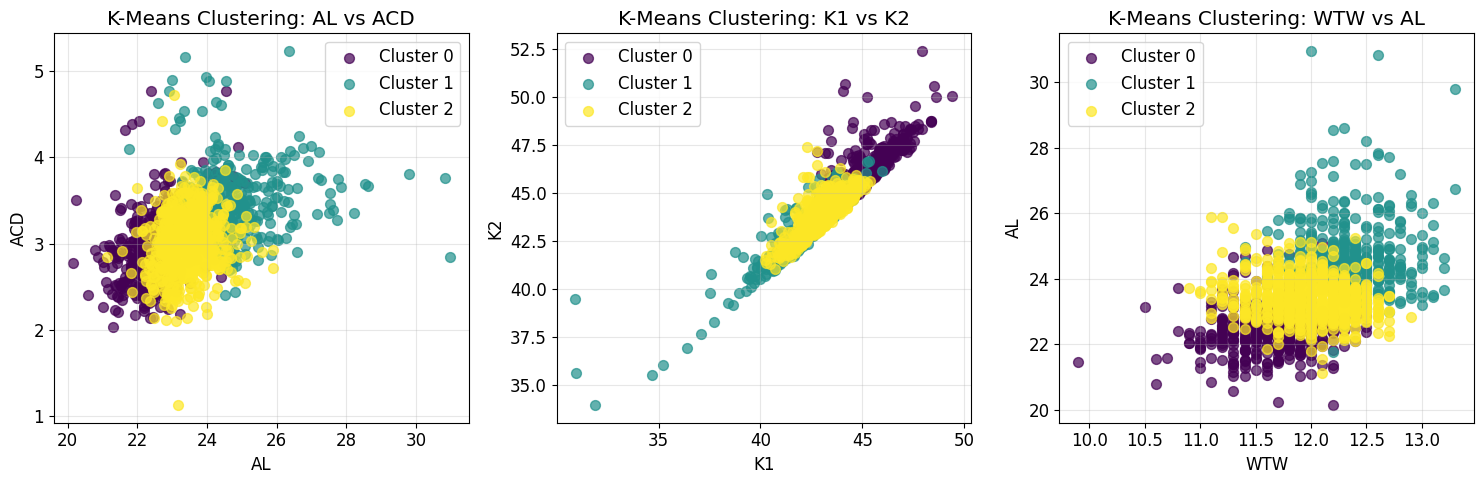

In [10]:
# Visualização dos clusters K-Means
def plot_clusters_2d(X_original, labels, title, feature_pairs=None):
    """Plota clusters em 2D para diferentes pares de features"""
    if feature_pairs is None:
        feature_pairs = [('AL', 'ACD'), ('K1', 'K2'), ('WTW', 'AL')]
    
    fig, axes = plt.subplots(1, len(feature_pairs), figsize=(5*len(feature_pairs), 5))
    if len(feature_pairs) == 1:
        axes = [axes]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
    
    for idx, (feat_x, feat_y) in enumerate(feature_pairs):
        for cluster in np.unique(labels):
            if cluster == -1:  # Para DBSCAN, pontos de ruído
                axes[idx].scatter(X_original[labels == cluster][feat_x], 
                                X_original[labels == cluster][feat_y], 
                                c='red', marker='x', s=50, alpha=0.6, label='Ruído')
            else:
                axes[idx].scatter(X_original[labels == cluster][feat_x], 
                                X_original[labels == cluster][feat_y], 
                                c=[colors[cluster]], s=50, alpha=0.7, 
                                label=f'Cluster {cluster}')
        
        axes[idx].set_xlabel(feat_x)
        axes[idx].set_ylabel(feat_y)
        axes[idx].set_title(f'{title}: {feat_x} vs {feat_y}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plotar clusters K-Means
plot_clusters_2d(X, kmeans_labels, 'K-Means Clustering')

## 5. Clustering com K-Medoids

### 5.1 Aplicação do K-Medoids

In [11]:
# Configurações para K-Medoids
KMEDOIDS_N_CLUSTERS = 3  # Configurável
KMEDOIDS_METHOD = 'pam'  # Configurável: 'pam' ou 'alternate'

# Aplicação do K-Medoids
kmedoids = KMedoids(n_clusters=KMEDOIDS_N_CLUSTERS, method=KMEDOIDS_METHOD, random_state=42)
kmedoids_labels = kmedoids.fit_predict(X_scaled)

# Métricas de avaliação
kmedoids_sil = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_cal = calinski_harabasz_score(X_scaled, kmedoids_labels)
kmedoids_db = davies_bouldin_score(X_scaled, kmedoids_labels)

print(f"RESULTADOS K-MEDOIDS (k={KMEDOIDS_N_CLUSTERS}, método={KMEDOIDS_METHOD})")
print("="*60)
print(f"Silhouette Score: {kmedoids_sil:.4f}")
print(f"Calinski-Harabasz Score: {kmedoids_cal:.2f}")
print(f"Davies-Bouldin Score: {kmedoids_db:.4f}")
print(f"Inércia: {kmedoids.inertia_:.2f}")

# Adicionar labels ao dataframe
df_kmedoids = df.copy()
df_kmedoids['KMedoids_Cluster'] = kmedoids_labels

# Contagem de pontos por cluster
cluster_counts = pd.Series(kmedoids_labels).value_counts().sort_index()
print(f"\nDistribuição dos pontos por cluster:")
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} pontos ({count/len(kmedoids_labels)*100:.1f}%)")

# Informações dos medoids
medoid_indices = kmedoids.medoid_indices_
print(f"\nÍndices dos medoides: {medoid_indices}")
print(f"\nCaracterísticas dos medoides:")
medoids_df = X.iloc[medoid_indices].copy()
medoids_df.index = [f'Medoide_Cluster_{i}' for i in range(len(medoid_indices))]
print(medoids_df)

RESULTADOS K-MEDOIDS (k=3, método=pam)
Silhouette Score: 0.2195
Calinski-Harabasz Score: 593.98
Davies-Bouldin Score: 1.4709
Inércia: 2282.21

Distribuição dos pontos por cluster:
Cluster 0: 534 pontos (34.9%)
Cluster 1: 339 pontos (22.2%)
Cluster 2: 655 pontos (42.9%)

Índices dos medoides: [1302  462   73]

Características dos medoides:
                      AL   ACD   WTW     K1     K2
Medoide_Cluster_0  22.57  2.97  11.7  45.12  45.61
Medoide_Cluster_1  24.76  3.51  12.4  42.08  42.78
Medoide_Cluster_2  23.72  3.02  12.0  43.10  43.77


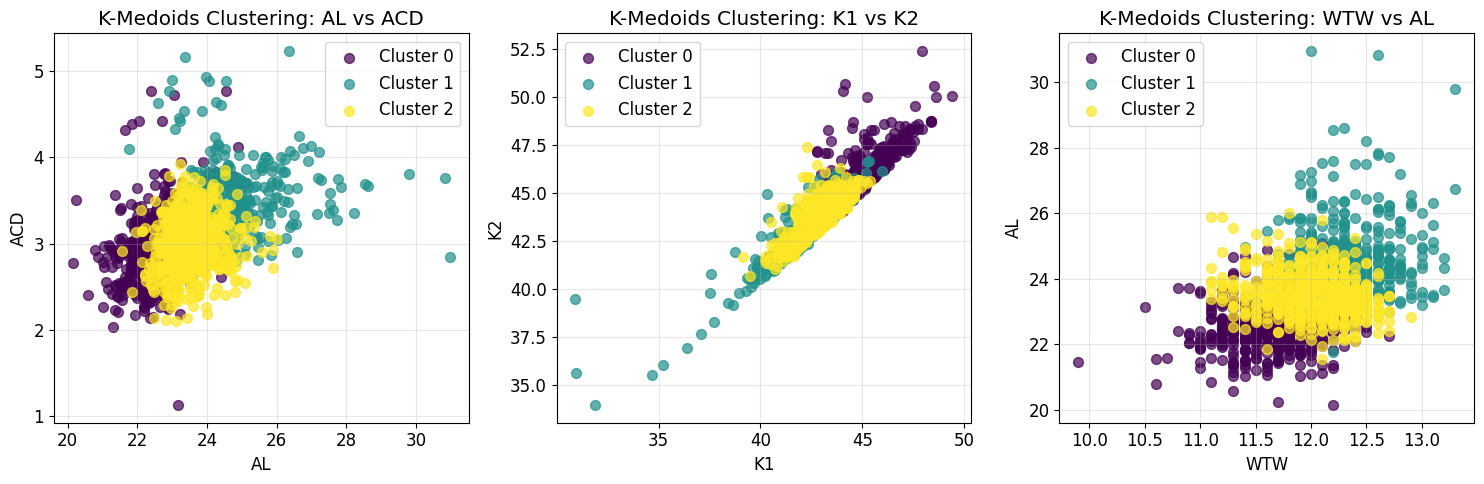

In [12]:
# Visualização dos clusters K-Medoids
plot_clusters_2d(X, kmedoids_labels, 'K-Medoids Clustering')

## 6. Clustering com DBSCAN

### 6.1 Determinação dos Parâmetros Ótimos

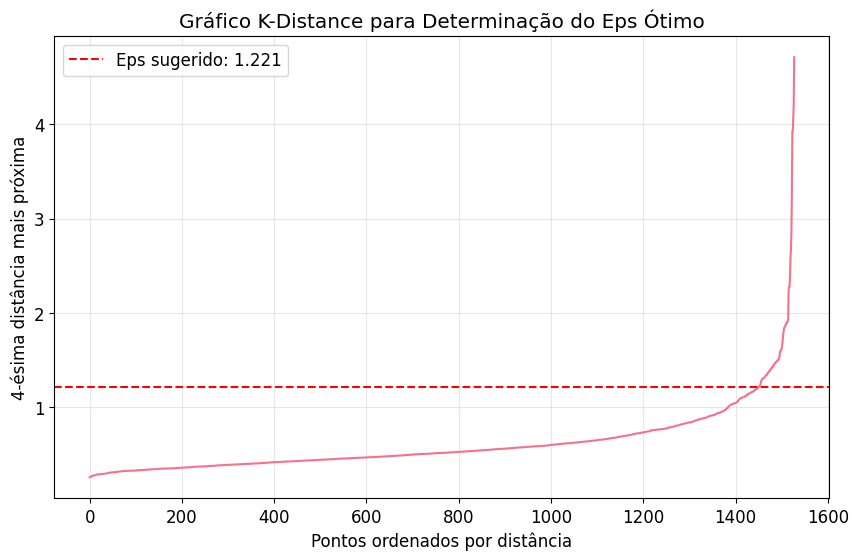

Eps sugerido baseado no método k-distance: 1.221


In [13]:
# Método k-distance para encontrar eps ótimo
def find_optimal_eps(X, k=4):
    """Encontra o eps ótimo usando o método k-distance"""
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Ordena as distâncias do k-ésimo vizinho mais próximo
    distances = np.sort(distances[:, k-1], axis=0)
    
    return distances

# Calcular k-distance
k_distance = find_optimal_eps(X_scaled, k=4)

# Plotar k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distance)
plt.xlabel('Pontos ordenados por distância')
plt.ylabel('4-ésima distância mais próxima')
plt.title('Gráfico K-Distance para Determinação do Eps Ótimo')
plt.grid(True, alpha=0.3)

# Adicionar linha para eps sugerido
suggested_eps = k_distance[int(len(k_distance) * 0.95)]  # 95º percentil
plt.axhline(y=suggested_eps, color='red', linestyle='--', 
           label=f'Eps sugerido: {suggested_eps:.3f}')
plt.legend()
plt.show()

print(f"Eps sugerido baseado no método k-distance: {suggested_eps:.3f}")

In [14]:
# Teste de diferentes parâmetros para DBSCAN
def test_dbscan_parameters(X, eps_range=None, min_samples_range=None):
    """Testa diferentes combinações de parâmetros para DBSCAN"""
    if eps_range is None:
        eps_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    if min_samples_range is None:
        min_samples_range = [3, 4, 5, 6, 7, 8]
        
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            result = {
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': n_noise / len(labels)
            }
            
            # Calcula métricas apenas se houver mais de 1 cluster
            if n_clusters > 1:
                mask = labels != -1
                if mask.sum() > 0:
                    try:
                        result['silhouette'] = silhouette_score(X[mask], labels[mask])
                    except:
                        result['silhouette'] = np.nan
                else:
                    result['silhouette'] = np.nan
            else:
                result['silhouette'] = np.nan
            
            results.append(result)
    
    return pd.DataFrame(results)

# Testar parâmetros
dbscan_results = test_dbscan_parameters(X_scaled)

# Filtrar resultados válidos (com clusters e silhouette score)
valid_results = dbscan_results.dropna(subset=['silhouette'])
valid_results = valid_results[valid_results['n_clusters'] > 1]

if len(valid_results) > 0:
    # Encontrar os melhores parâmetros
    best_result = valid_results.loc[valid_results['silhouette'].idxmax()]
    
    print("ANÁLISE DE PARÂMETROS DBSCAN")
    print("="*50)
    print(f"Melhores parâmetros:")
    print(f"  eps: {best_result['eps']}")
    print(f"  min_samples: {best_result['min_samples']}")
    print(f"  Silhouette Score: {best_result['silhouette']:.4f}")
    print(f"  Número de clusters: {best_result['n_clusters']}")
    print(f"  Pontos de ruído: {best_result['n_noise']} ({best_result['noise_ratio']*100:.1f}%)")
    
    # Mostrar top 5 combinações
    print(f"\nTop 5 combinações de parâmetros:")
    top_5 = valid_results.nlargest(5, 'silhouette')
    print(top_5[['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette', 'noise_ratio']])
else:
    print("Nenhuma combinação de parâmetros válida encontrada. Usando parâmetros padrão.")
    best_result = {'eps': 0.5, 'min_samples': 5}

ANÁLISE DE PARÂMETROS DBSCAN
Melhores parâmetros:
  eps: 0.3
  min_samples: 5.0
  Silhouette Score: 0.4487
  Número de clusters: 6.0
  Pontos de ruído: 1494.0 (97.8%)

Top 5 combinações de parâmetros:
    eps  min_samples  n_clusters  n_noise  silhouette  noise_ratio
2   0.3            5           6     1494    0.448718     0.977749
1   0.3            4          16     1438    0.429891     0.941099
0   0.3            3          47     1315    0.340665     0.860602
28  0.7            7           2      325    0.340566     0.212696
27  0.7            6           2      294    0.335947     0.192408


### 6.2 Aplicação do DBSCAN com Parâmetros Ótimos

In [15]:
# Configurações para DBSCAN
if len(valid_results) > 0:
    DBSCAN_EPS = best_result['eps']
    DBSCAN_MIN_SAMPLES = int(best_result['min_samples'])
else:
    DBSCAN_EPS = 0.5  # Configurável
    DBSCAN_MIN_SAMPLES = 5  # Configurável

# Aplicação do DBSCAN
dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Análise dos resultados
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"RESULTADOS DBSCAN (eps={DBSCAN_EPS}, min_samples={DBSCAN_MIN_SAMPLES})")
print("="*60)
print(f"Número de clusters encontrados: {n_clusters_dbscan}")
print(f"Número de pontos de ruído: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

# Métricas de avaliação (apenas para pontos não-ruído)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_sil = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_cal = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_db = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
        
        print(f"Silhouette Score: {dbscan_sil:.4f}")
        print(f"Calinski-Harabasz Score: {dbscan_cal:.2f}")
        print(f"Davies-Bouldin Score: {dbscan_db:.4f}")
    else:
        dbscan_sil = dbscan_cal = dbscan_db = np.nan
        print("Não foi possível calcular as métricas (poucos pontos válidos)")
else:
    dbscan_sil = dbscan_cal = dbscan_db = np.nan
    print("Nenhum cluster válido encontrado")

# Adicionar labels ao dataframe
df_dbscan = df.copy()
df_dbscan['DBSCAN_Cluster'] = dbscan_labels

# Contagem de pontos por cluster
if n_clusters_dbscan > 0:
    cluster_counts = pd.Series(dbscan_labels[dbscan_labels != -1]).value_counts().sort_index()
    print(f"\nDistribuição dos pontos por cluster (excluindo ruído):")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} pontos")

RESULTADOS DBSCAN (eps=0.3, min_samples=5)
Número de clusters encontrados: 6
Número de pontos de ruído: 1494 (97.8%)
Silhouette Score: 0.4487
Calinski-Harabasz Score: 38.44
Davies-Bouldin Score: 0.7526

Distribuição dos pontos por cluster (excluindo ruído):
Cluster 0: 5 pontos
Cluster 1: 5 pontos
Cluster 2: 7 pontos
Cluster 3: 5 pontos
Cluster 4: 4 pontos
Cluster 5: 8 pontos


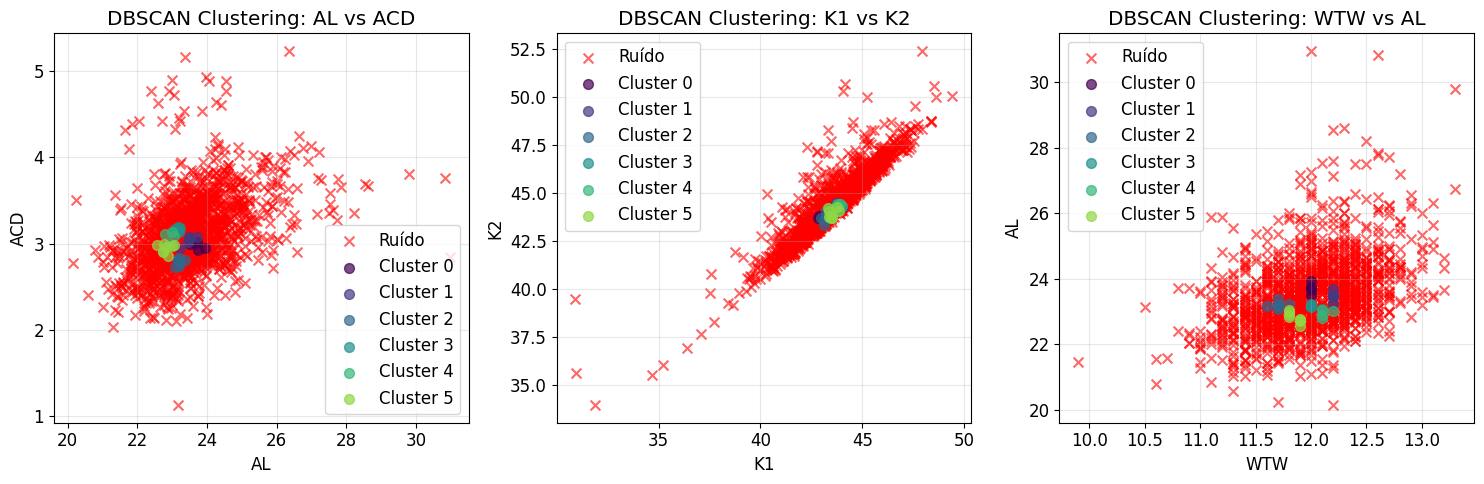

In [16]:
# Visualização dos clusters DBSCAN
plot_clusters_2d(X, dbscan_labels, 'DBSCAN Clustering')

## 7. Comparação dos Métodos

COMPARAÇÃO DOS MÉTODOS DE CLUSTERING
   Método  N_Clusters  Silhouette_Score  Calinski_Harabasz  Davies_Bouldin  Pontos_Ruído
  K-Means           3          0.223306         600.672186        1.443572             0
K-Medoids           3          0.219536         593.978329        1.470888             0
   DBSCAN           6          0.448718          38.435054        0.752591          1494


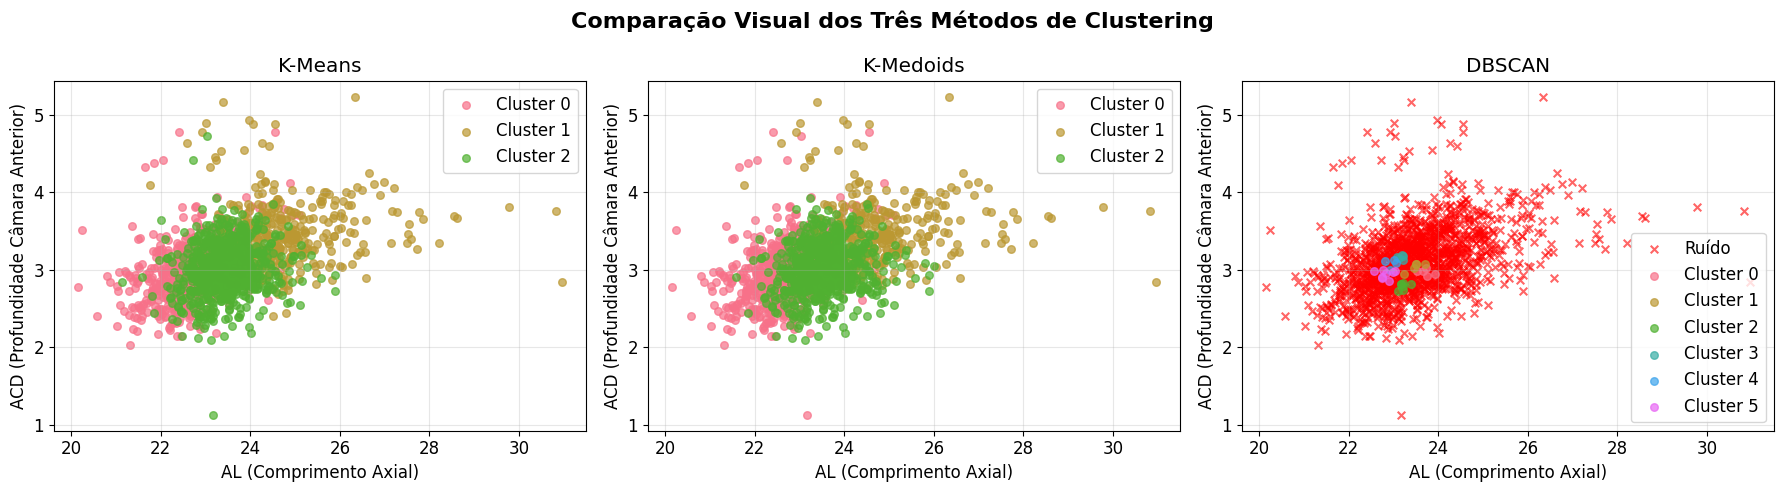

In [17]:
# Comparação dos três métodos
comparison_data = {
    'Método': ['K-Means', 'K-Medoids', 'DBSCAN'],
    'N_Clusters': [KMEANS_N_CLUSTERS, KMEDOIDS_N_CLUSTERS, n_clusters_dbscan],
    'Silhouette_Score': [kmeans_sil, kmedoids_sil, dbscan_sil if not np.isnan(dbscan_sil) else 'N/A'],
    'Calinski_Harabasz': [kmeans_cal, kmedoids_cal, dbscan_cal if not np.isnan(dbscan_cal) else 'N/A'],
    'Davies_Bouldin': [kmeans_db, kmedoids_db, dbscan_db if not np.isnan(dbscan_db) else 'N/A'],
    'Pontos_Ruído': [0, 0, n_noise]
}

comparison_df = pd.DataFrame(comparison_data)

print("COMPARAÇÃO DOS MÉTODOS DE CLUSTERING")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualização comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = ['K-Means', 'K-Medoids', 'DBSCAN']
labels_list = [kmeans_labels, kmedoids_labels, dbscan_labels]

for i, (method, labels) in enumerate(zip(methods, labels_list)):
    # Usar AL vs ACD para comparação
    for cluster in np.unique(labels):
        if cluster == -1:  # Ruído no DBSCAN
            axes[i].scatter(X[labels == cluster]['AL'], 
                          X[labels == cluster]['ACD'], 
                          c='red', marker='x', s=30, alpha=0.6, label='Ruído')
        else:
            axes[i].scatter(X[labels == cluster]['AL'], 
                          X[labels == cluster]['ACD'], 
                          s=30, alpha=0.7, label=f'Cluster {cluster}')
    
    axes[i].set_xlabel('AL (Comprimento Axial)')
    axes[i].set_ylabel('ACD (Profundidade Câmara Anterior)')
    axes[i].set_title(f'{method}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Comparação Visual dos Três Métodos de Clustering', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Perfil dos Grupos Encontrados

### 8.1 Seleção do Melhor Método

In [18]:
# Determinar o melhor método baseado nas métricas
scores = []
if not np.isnan(kmeans_sil):
    scores.append(('K-Means', kmeans_sil))
if not np.isnan(kmedoids_sil):
    scores.append(('K-Medoids', kmedoids_sil))
if not np.isnan(dbscan_sil):
    scores.append(('DBSCAN', dbscan_sil))

if scores:
    best_method, best_score = max(scores, key=lambda x: x[1])
    print(f"MELHOR MÉTODO BASEADO NO SILHOUETTE SCORE")
    print("="*50)
    print(f"Método: {best_method}")
    print(f"Silhouette Score: {best_score:.4f}")
    
    # Selecionar os labels do melhor método
    if best_method == 'K-Means':
        best_labels = kmeans_labels
        best_df = df_kmeans
    elif best_method == 'K-Medoids':
        best_labels = kmedoids_labels
        best_df = df_kmedoids
    else:
        best_labels = dbscan_labels
        best_df = df_dbscan
else:
    print("Usando K-Means como método padrão")
    best_method = 'K-Means'
    best_labels = kmeans_labels
    best_df = df_kmeans

MELHOR MÉTODO BASEADO NO SILHOUETTE SCORE
Método: DBSCAN
Silhouette Score: 0.4487


### 8.2 Análise Detalhada dos Perfis de Olhos

In [19]:
# Análise estatística dos grupos encontrados pelo melhor método
cluster_column = f'{best_method.replace("-", "")}_Cluster'

# Estatísticas por cluster
cluster_stats = best_df.groupby(cluster_column)[features].agg(['mean', 'std', 'min', 'max']).round(2)

print(f"PERFIL DOS GRUPOS - MÉTODO {best_method}")
print("="*70)
print("Estatísticas por cluster:")
print(cluster_stats)

# Contagem e percentual por cluster
cluster_counts = best_df[cluster_column].value_counts().sort_index()
print(f"\nDistribuição dos grupos:")
for cluster, count in cluster_counts.items():
    if cluster != -1:  # Ignorar ruído
        percentage = (count / len(best_df)) * 100
        print(f"Grupo {cluster}: {count} olhos ({percentage:.1f}%)")

# Análise da coluna 'Correto' como complemento (conforme orientações)
if 'Correto' in best_df.columns:
    print(f"\n" + "="*70)
    print("COMPLEMENTO: Distribuição da coluna 'Correto' por grupo")
    print("(IMPORTANTE: Esta análise é apenas complementar e NÃO foi usada para clustering)")
    print("="*70)
    
    cross_tab = pd.crosstab(best_df[cluster_column], best_df['Correto'], margins=True)
    print(cross_tab)
    
    # Percentual dentro de cada cluster
    print(f"\nPercentual de 'Correto' dentro de cada grupo:")
    for cluster in sorted(best_df[cluster_column].unique()):
        if cluster != -1:  # Ignorar ruído
            cluster_data = best_df[best_df[cluster_column] == cluster]
            correto_pct = (cluster_data['Correto'] == 'S').mean() * 100
            print(f"Grupo {cluster}: {correto_pct:.1f}% de casos 'Correto' = S")

PERFIL DOS GRUPOS - MÉTODO DBSCAN
Estatísticas por cluster:
                   AL                       ACD                      WTW  \
                 mean   std    min    max  mean   std   min   max   mean   
DBSCAN_Cluster                                                             
-1              23.49  1.15  20.15  30.96  3.11  0.43  1.13  5.23  11.98   
 0              23.71  0.15  23.52  23.93  2.97  0.04  2.92  3.02  12.00   
 1              23.48  0.16  23.24  23.70  3.04  0.06  2.95  3.08  12.20   
 2              23.20  0.09  23.09  23.38  2.79  0.04  2.73  2.83  11.70   
 3              23.16  0.06  23.07  23.22  3.16  0.02  3.13  3.19  12.02   
 4              22.95  0.11  22.81  23.06  3.08  0.06  3.00  3.13  12.12   
 5              22.82  0.15  22.57  23.04  2.94  0.05  2.86  3.00  11.85   

                                     K1                         K2        \
                 std   min   max   mean   std    min    max   mean   std   
DBSCAN_Cluster             

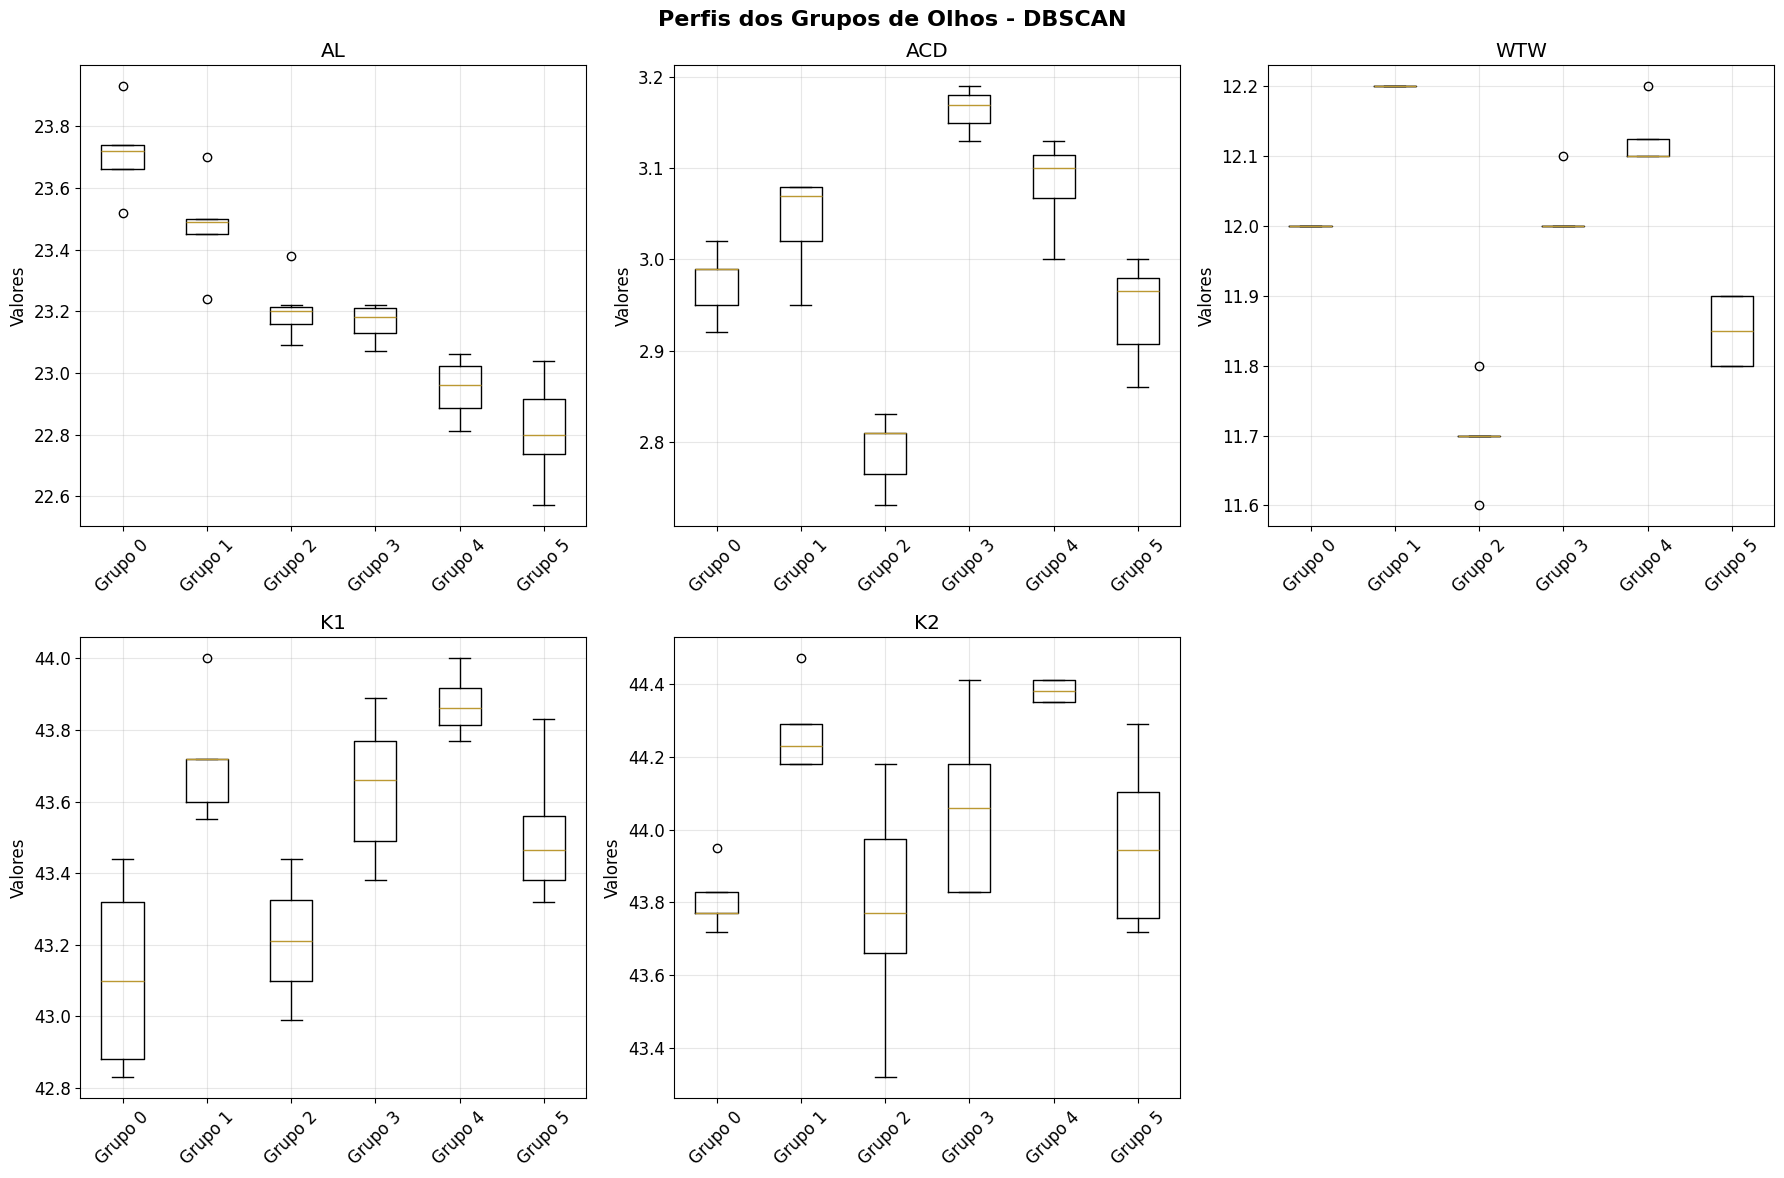

In [20]:
# Visualização dos perfis dos grupos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Perfis dos Grupos de Olhos - {best_method}', fontsize=16, fontweight='bold')

colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    
    # Box plot por cluster
    cluster_data = []
    cluster_labels = []
    
    for cluster in sorted(best_df[cluster_column].unique()):
        if cluster != -1:  # Ignorar ruído
            cluster_data.append(best_df[best_df[cluster_column] == cluster][feature])
            cluster_labels.append(f'Grupo {cluster}')
    
    axes[row, col].boxplot(cluster_data, labels=cluster_labels)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].set_ylabel('Valores')
    axes[row, col].grid(True, alpha=0.3)
    
    # Rotacionar labels se necessário
    if len(cluster_labels) > 3:
        axes[row, col].tick_params(axis='x', rotation=45)

# Remove o subplot extra se houver
if len(features) == 5:
    axes[1, 2].remove()

plt.tight_layout()
plt.show()

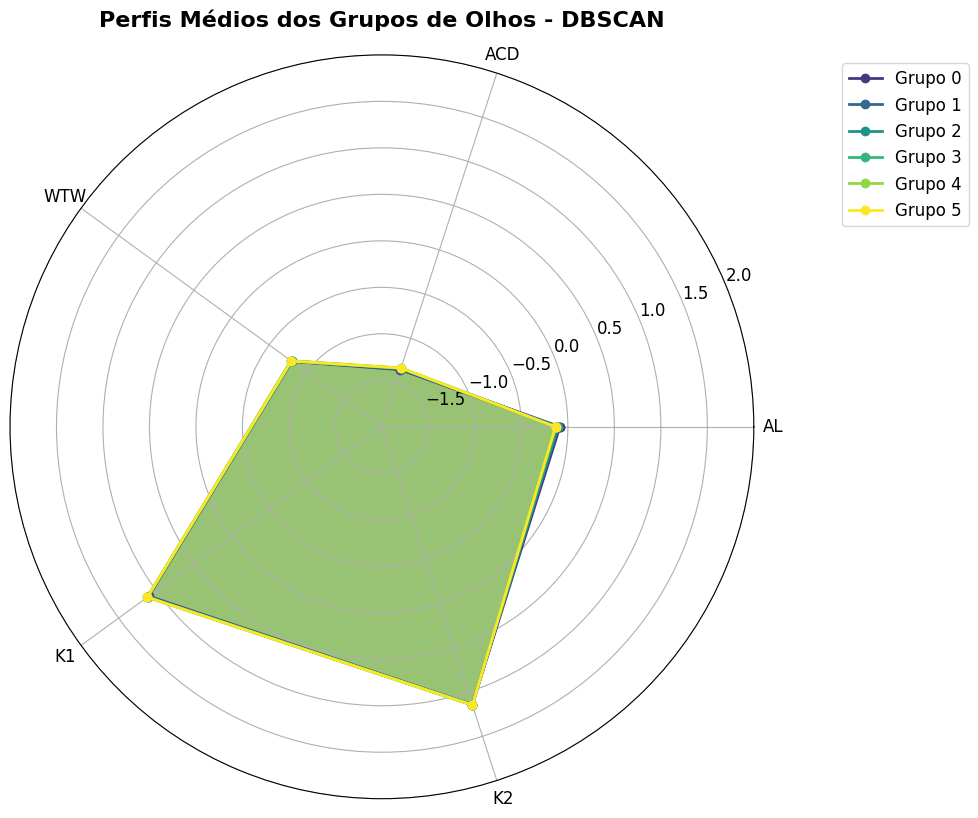

In [21]:
# Radar chart dos perfis médios
def create_radar_chart(df, cluster_column, features, title):
    """Cria um gráfico radar com os perfis médios dos clusters"""
    
    # Calcular médias por cluster
    cluster_means = df.groupby(cluster_column)[features].mean()
    
    # Normalizar para escala 0-1 para melhor visualização
    scaler_viz = StandardScaler()
    normalized_means = pd.DataFrame(
        scaler_viz.fit_transform(cluster_means.T).T,
        columns=features,
        index=cluster_means.index
    )
    
    # Configuração do gráfico radar
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]  # Fechar o círculo
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(normalized_means)))
    
    for i, (cluster, row) in enumerate(normalized_means.iterrows()):
        if cluster != -1:  # Ignorar ruído
            values = row.tolist()
            values += values[:1]  # Fechar o círculo
            
            ax.plot(angles, values, 'o-', linewidth=2, label=f'Grupo {cluster}', 
                   color=colors[i])
            ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Configurações do gráfico
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_ylim(-2, 2)
    ax.set_title(title, size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Criar radar chart
create_radar_chart(best_df, cluster_column, features, 
                  f'Perfis Médios dos Grupos de Olhos - {best_method}')

### 8.3 Interpretação dos Perfis de Olhos

In [22]:
# Descrição detalhada dos perfis encontrados
print("INTERPRETAÇÃO DOS PERFIS DE OLHOS IDENTIFICADOS")
print("="*80)
print(f"Método utilizado: {best_method}")
print(f"Número de grupos identificados: {len(cluster_counts)}")
print()

# Calcular médias por cluster para interpretação
cluster_means = best_df.groupby(cluster_column)[features].mean().round(2)

# Interpretação automática baseada nas médias
for cluster in sorted(cluster_means.index):
    if cluster != -1:  # Ignorar ruído
        print(f"GRUPO {cluster}:")
        print("-" * 40)
        
        # Características do grupo
        means = cluster_means.loc[cluster]
        count = cluster_counts[cluster]
        percentage = (count / len(best_df)) * 100
        
        print(f"Tamanho do grupo: {count} olhos ({percentage:.1f}% do total)")
        print()
        print("Características anatômicas médias:")
        
        for feature in features:
            value = means[feature]
            
            # Interpretação baseada nas médias gerais
            overall_mean = best_df[feature].mean()
            
            if value > overall_mean * 1.1:
                level = "ALTO"
            elif value < overall_mean * 0.9:
                level = "BAIXO"
            else:
                level = "MÉDIO"
            
            feature_names = {
                'AL': 'Comprimento axial do olho',
                'ACD': 'Profundidade da câmara anterior',
                'WTW': 'Distância branco a branco',
                'K1': 'Curvatura no meridiano menos curvo',
                'K2': 'Curvatura no meridiano mais curvo'
            }
            
            print(f"  • {feature_names[feature]} ({feature}): {value:.2f} ({level})")
        
        print()
        
        # Interpretação clínica simplificada
        al_value = means['AL']
        acd_value = means['ACD']
        k1_value = means['K1']
        k2_value = means['K2']
        
        print("Interpretação clínica sugerida:")
        
        if al_value < 22.5:
            print("  • Olho relativamente curto (possível tendência à hipermetropia)")
        elif al_value > 24.5:
            print("  • Olho relativamente longo (possível tendência à miopia)")
        else:
            print("  • Comprimento axial dentro da normalidade")
            
        if acd_value < 2.8:
            print("  • Câmara anterior rasa")
        elif acd_value > 3.5:
            print("  • Câmara anterior profunda")
        else:
            print("  • Profundidade da câmara anterior normal")
            
        if k1_value > 44 or k2_value > 44:
            print("  • Córnea relativamente curva (córnea mais íngreme)")
        elif k1_value < 41 or k2_value < 41:
            print("  • Córnea relativamente plana")
        else:
            print("  • Curvatura corneana dentro da normalidade")
            
        astigmatism = abs(k2_value - k1_value)
        if astigmatism > 1.5:
            print(f"  • Astigmatismo significativo ({astigmatism:.2f}D)")
        elif astigmatism > 0.75:
            print(f"  • Astigmatismo moderado ({astigmatism:.2f}D)")
        else:
            print(f"  • Astigmatismo mínimo ({astigmatism:.2f}D)")
        
        print("\n" + "="*80 + "\n")

INTERPRETAÇÃO DOS PERFIS DE OLHOS IDENTIFICADOS
Método utilizado: DBSCAN
Número de grupos identificados: 7

GRUPO 0:
----------------------------------------
Tamanho do grupo: 5 olhos (0.3% do total)

Características anatômicas médias:
  • Comprimento axial do olho (AL): 23.71 (MÉDIO)
  • Profundidade da câmara anterior (ACD): 2.97 (MÉDIO)
  • Distância branco a branco (WTW): 12.00 (MÉDIO)
  • Curvatura no meridiano menos curvo (K1): 43.11 (MÉDIO)
  • Curvatura no meridiano mais curvo (K2): 43.81 (MÉDIO)

Interpretação clínica sugerida:
  • Comprimento axial dentro da normalidade
  • Profundidade da câmara anterior normal
  • Curvatura corneana dentro da normalidade
  • Astigmatismo mínimo (0.70D)


GRUPO 1:
----------------------------------------
Tamanho do grupo: 5 olhos (0.3% do total)

Características anatômicas médias:
  • Comprimento axial do olho (AL): 23.48 (MÉDIO)
  • Profundidade da câmara anterior (ACD): 3.04 (MÉDIO)
  • Distância branco a branco (WTW): 12.20 (MÉDIO)
  • Cu

## 9. Conclusões e Recomendações

### Resumo Executivo

In [23]:
# Salvar resultados finais
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# Salvar dados com clusters
best_df.to_csv(output_dir / f'{best_method.lower().replace("-", "_")}_clusters.csv', index=False)

# Salvar resumo dos perfis
cluster_summary = best_df.groupby(cluster_column)[features].agg(['mean', 'std', 'count']).round(3)
cluster_summary.to_csv(output_dir / f'{best_method.lower().replace("-", "_")}_profiles.csv')

print("ANÁLISE CONCLUÍDA COM SUCESSO!")
print("="*60)
print(f"✓ Três métodos de clustering foram implementados e comparados")
print(f"✓ O método {best_method} foi identificado como o mais adequado")
print(f"✓ {len(cluster_counts)} perfis distintos de olhos foram identificados")
print(f"✓ Resultados salvos na pasta 'results/'")
print()
print("PRINCIPAIS DESCOBERTAS:")
print("="*60)

# Resumo dos principais achados
total_groups = len([c for c in cluster_counts.index if c != -1])
print(f"• Identificados {total_groups} grupos distintos de perfis de olhos")
print(f"• Cada grupo possui características anatômicas específicas")
print(f"• Os grupos diferem principalmente em:")

# Encontrar as variáveis com maior variação entre clusters
cluster_means = best_df.groupby(cluster_column)[features].mean()
if len(cluster_means) > 1:
    variation_coeffs = cluster_means.std() / cluster_means.mean()
    top_varying = variation_coeffs.nlargest(3)
    
    for feature in top_varying.index:
        feature_names = {
            'AL': 'Comprimento axial do olho',
            'ACD': 'Profundidade da câmara anterior',
            'WTW': 'Distância branco a branco',
            'K1': 'Curvatura no meridiano menos curvo',
            'K2': 'Curvatura no meridiano mais curvo'
        }
        print(f"  - {feature_names[feature]} (coef. variação: {top_varying[feature]:.3f})")

print()
print("APLICAÇÕES PRÁTICAS:")
print("="*60)
print("• Personalização de tratamentos oftalmológicos")
print("• Seleção de lentes de contato adequadas")
print("• Planejamento cirúrgico mais preciso")
print("• Identificação de padrões de risco oftalmológico")
print("• Desenvolvimento de novas tecnologias oftálmicas")

print()
print("RECOMENDAÇÕES PARA TRABALHOS FUTUROS:")
print("="*60)
print("• Validação clínica dos grupos identificados")
print("• Análise longitudinal dos perfis")
print("• Incorporação de dados demográficos")
print("• Estudo de correlações com patologias específicas")
print("• Desenvolvimento de sistema de classificação automática")

ANÁLISE CONCLUÍDA COM SUCESSO!
✓ Três métodos de clustering foram implementados e comparados
✓ O método DBSCAN foi identificado como o mais adequado
✓ 7 perfis distintos de olhos foram identificados
✓ Resultados salvos na pasta 'results/'

PRINCIPAIS DESCOBERTAS:
• Identificados 6 grupos distintos de perfis de olhos
• Cada grupo possui características anatômicas específicas
• Os grupos diferem principalmente em:
  - Profundidade da câmara anterior (coef. variação: 0.042)
  - Distância branco a branco (coef. variação: 0.014)
  - Comprimento axial do olho (coef. variação: 0.014)

APLICAÇÕES PRÁTICAS:
• Personalização de tratamentos oftalmológicos
• Seleção de lentes de contato adequadas
• Planejamento cirúrgico mais preciso
• Identificação de padrões de risco oftalmológico
• Desenvolvimento de novas tecnologias oftálmicas

RECOMENDAÇÕES PARA TRABALHOS FUTUROS:
• Validação clínica dos grupos identificados
• Análise longitudinal dos perfis
• Incorporação de dados demográficos
• Estudo de c